In [1]:
import numpy as np
import torch
from torch import nn
import networkx as nx
import copy
import circuits as ckt

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

# torch.autograd.set_detect_anomaly(True)

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

Circuit with 2 nodes and 2 elements
[0, 1]
[(1 , 0), (1 , 0)]
[(1, {}), (0, {})]
[(1, 0, 0, {'kind': <Kinds.IVS: 0>, 'i': None, 'v': None, 'attr': 2}), (1, 0, 1, {'kind': <Kinds.R: 2>, 'i': 0.001, 'v': None, 'attr': None})]


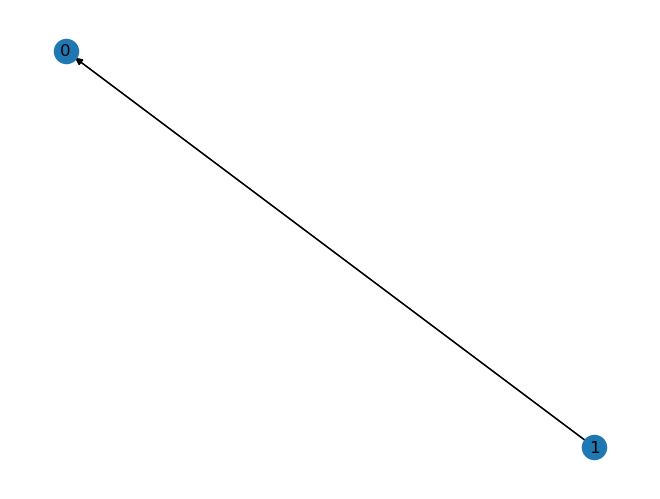

In [3]:
vr = ckt.Circuit()
v_source = vr.add_element(kind=ckt.Kinds.IVS)
resistor = vr.add_element(kind=ckt.Kinds.R)
v_source.connect(v_source.high, resistor.high)
v_source.connect(v_source.low, resistor.low)
v_source.attr = 2
resistor.i = 0.001
print(vr)
print(vr.nodes)
print(vr.elements)
vr.draw()
print(vr.nx_graph().nodes().data())
print(vr.nx_graph().edges(data=True,keys=True))

# Expected Sizes of Vectors

In [4]:
# create tensors for voltages, currents, and element attrs
print(f'size of element currents, voltages, and attr = ({vr.num_elements()},1)')
print(f'size of node voltages = ({vr.num_nodes()},1)')

size of element currents, voltages, and attr = (2,1)
size of node voltages = (2,1)


# Extract Circuit Inputs for the Model

In [5]:
input = ckt.Input(vr)

Kinds.IVS
Kinds.R


c:\Users\terry\OneDrive\Documents\GitHub\side_circuit\ml\circuits.py:64: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_scipy = nx.incidence_matrix(G=self.nx_graph(),oriented=True)


In [6]:
input.M

tensor([[-1., -1.],
        [ 1.,  1.]])

In [7]:
input.kinds_map

{<Kinds.IVS: 0>: [True, False],
 <Kinds.ICS: 1>: [False, False],
 <Kinds.R: 2>: [False, True]}

In [8]:
input.knowns_map

{<Props.I: 0>: [False, True],
 <Props.V: 1>: [True, False],
 <Props.Attr: 2>: [True, False]}

In [9]:
input.inputs_map

{<Props.I: 0>: [0.20411150296470304, 0.001],
 <Props.V: 1>: [2.0, 0.9157723305840797],
 <Props.Attr: 2>: [2.0, 0.44676224655091024]}

In [10]:
input.init_tensors()

(tensor([[0.2041],
         [0.0010]]),
 tensor([[2.0000],
         [0.9158]]),
 tensor([[0.0432],
         [0.4618]]),
 tensor([[2.0000],
         [0.4468]]))

# Define Models

In [11]:
class Solver(nn.Module):
    def __init__(self, input: ckt.Input):
        super().__init__()
        self.input = input
        i_in, v_in, pot_in, attr_in = self.input.init_tensors()
        self.i = nn.Parameter(i_in.clone().detach())
        self.v = nn.Parameter(v_in.clone().detach())
        self.pot = nn.Parameter(pot_in.clone().detach())
        self.attr = nn.Parameter(attr_in.clone().detach())

    def forward(self):
        current_error = self.kcl(input.M, self.i)
        voltage_error = self.kvl(input.M, self.v, self.pot)
        resistor_error = self.resistor(self.i, self.v, self.attr)
        return current_error, voltage_error, resistor_error

    def kcl(self, M, i):
        current_error = M @ i
        return current_error

    def kvl(self,M,v,pot):
        kvl_error = v - M.T @ pot
        return kvl_error

    def resistor(self,i,v,r):
        resistor_v_error = i * r - v
        return resistor_v_error

    def zero_kcl_known_grads(self):
        self.i.grad[self.input.knowns_map[ckt.Props.I]] = 0
        
    def zero_kvl_known_grads(self):
        self.v.grad[self.input.knowns_map[ckt.Props.V]] = 0

    def zero_res_known_grads(self):
        self.v.grad[self.input.knowns_map[ckt.Props.V]] = 0
        self.i.grad[self.input.knowns_map[ckt.Props.I]] = 0
        self.attr.grad[self.input.knowns_map[ckt.Props.Attr]] = 0

    def zero_known_grads(self):
        self.zero_kcl_known_grads()
        self.zero_kvl_known_grads()
        self.zero_res_known_grads()

# Create Instance of Models

In [12]:
model = Solver(input = input).to(device)

# Loss

In [13]:
loss_fn = nn.MSELoss()

# Optimizer

In [14]:
optimizer = torch.optim.Adam(params=model.parameters(),lr=0.9)

# Train Function

This is multitask learning since there are multiple losses accessing common, hard parameters.  By separating the losses, Adam optimizer can use different learning rates of different parameter groups.  Each loss is associated with a key equation for solving circuits (e.g. KCL).  There are three ways to backpropagate the losses.  

First is the common way.  Calculate all losses, sum them, then backpropogate from the final summed loss.  This does not work because larger losses overpower smaller losses.  A way to fix that is to add a scaling factor to each loss before summing.  Does not work in this scenario because the ranges for the losses change depending on the circuit and constraints.  The second way is to individually backpropagate each loss before one optimizer update.  The three models battle it this case.  The fix for this is to run an optimizer step after each loss backprop.  Therefore each loss is it's own model that takes shared parameters as input and returns an update of the parameters for use by the next loss backprop + opt step.

Note:  At one point the `retain_graph = True` input for `loss.backward()` method was used to retain computation of the entire graph for all the losses before freeing from memory.  Useful for the case when having to call multiple loss.backward() in a row without an optimizer step.  Bascially adding all contributions of gradients from all losses to a shared parameter.  Unstable.

Model struggles with large differences in values (1 vs 100 Ohms in the same circuit).  It needs some form of normalization.  Normalization needs to be treated as max of v_input is v_base and max of i_input is i_base and derive all other bases from i_base and v_base.  For example, r_base = v_base / i_base.

Freezing parameters, especially resistance, allows the model to train itself from different perpectives.  This is done by zeroing the gradients for an entire set of parameters.  Freezing is always done for any "known" parameters.

# Using combined losses is better than treating losses separately

In [15]:
epochs = 10000

prev_loss = 0.1
lt_prev_loss = 1000

for t in range(epochs):

    #set training mode
    model.train()

    i_error, v_error, r_error = model()
    i_loss = loss_fn(i_error, torch.zeros_like(i_error))
    v_loss = loss_fn(v_error, torch.zeros_like(v_error))
    r_loss = loss_fn(r_error, torch.zeros_like(r_error))

    loss = i_loss + v_loss + r_loss

    model.zero_grad()

    loss.backward()

    model.zero_known_grads()

    optimizer.step()

    # analyze steps and loss
    loss_change = abs(loss - prev_loss) / prev_loss
    prev_loss = loss

    if (t % (epochs/10)) == 0:
        print(f'epoch {t} loss: {loss.item()}')
        if loss > lt_prev_loss:
            for g in optimizer.param_groups:
                g['lr'] /= 2
        lt_prev_loss = loss

    # if (loss_change < 1e-45):
    #     print(f'epoch {t} loss = {loss} finished early for loss change')
    #     break

    if loss < 1e-10:
        print(f'epoch {t} loss = {loss} finished early for loss threshold')
        break

print("Done!")
print(f"params = {list(model.parameters())}")

epoch 0 loss: 3.52864670753479
epoch 1000 loss: 0.9088379144668579
epoch 2000 loss: 0.7273942828178406
epoch 3000 loss: 0.6754524111747742
epoch 4000 loss: 0.6683515310287476
epoch 5000 loss: 0.6682814955711365
epoch 6000 loss: 0.6684752702713013
epoch 7000 loss: 0.6680006384849548
epoch 8000 loss: 0.6683152914047241
epoch 9000 loss: 0.6680006384849548
Done!
params = [Parameter containing:
tensor([[0.6663],
        [0.0010]], requires_grad=True), Parameter containing:
tensor([[2.0000],
        [2.0004]], requires_grad=True), Parameter containing:
tensor([[-0.6830],
        [ 1.3163]], requires_grad=True), Parameter containing:
tensor([[   2.0000],
        [1999.9995]], requires_grad=True)]
